In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import xarray as xr

import subprocess
from datetime import timedelta

# from cht_hurrywave.bathymetry import HurryWaveBathymetry
# from cht_hurrywave.mask import HurryWaveMask
# from cht_bathymetry.database import Bathymetry Database
from pyproj import CRS 
from pyproj import Transformer

import geopandas as gpd
from shapely.geometry import Polygon
from datetime import datetime, timedelta
import re
from pathlib import Path


In [2]:
outfolder = "/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/04_modelruns/YearSims"

In [5]:
def parse_hurrywave_logs(filepaths):
    """
    Parse one or more hurrywave .out files and extract runtimes per year.
    
    Parameters
    ----------
    filepaths : str or list of str
        Path(s) to .out log file(s).
    
    Returns
    -------
    dict
        Dictionary {year: runtime_in_seconds}.
    """
    
    if isinstance(filepaths, (str, Path)):
        filepaths = [filepaths]
    
    results = {}
    
    # Regex patterns
    start_pattern = re.compile(r"Time before hurrywave: (.+)")
    end_pattern   = re.compile(r"Time after hurrywave:\s+(.+)")
    year_pattern  = re.compile(r"Running hurrywave for year (\d{4})")
    
    for filepath in filepaths:
        with open(filepath, "r") as f:
            lines = f.readlines()
        
        year = None
        start_time = None
        end_time = None
        
        for line in lines:
            # Detect year
            year_match = year_pattern.search(line)
            if year_match:
                year = int(year_match.group(1))
                start_time = None
                end_time = None
                continue
            
            # Detect start
            start_match = start_pattern.search(line)
            if start_match:
                start_time = datetime.strptime(start_match.group(1).strip(), "%a %b %d %H:%M:%S %Z %Y")
                continue
            
            # Detect end
            end_match = end_pattern.search(line)
            if end_match:
                end_time = datetime.strptime(end_match.group(1).strip(), "%a %b %d %H:%M:%S %Z %Y")
                if year and start_time and end_time:
                    runtime = (end_time - start_time).total_seconds()
                    results[year] = runtime
                year = None  # Reset after finishing one block
    
    return results

def parse_all_hurrywave_logs(folder):
    """
    Parse all .out files in a folder and combine runtimes into one dictionary.

    Parameters
    ----------
    folder : str or Path
        Path to the folder containing .out files.

    Returns
    -------
    dict
        Dictionary {year: runtime_in_seconds}.
    """
    folder = Path(folder)
    all_results = {}

    # Find all .out files
    out_files = sorted(folder.glob("*.out"))

    for f in out_files:
        results = parse_hurrywave_logs(f)
        for year, runtime in results.items():
            if year in all_results:
                raise ValueError(f"Duplicate year {year} found in {f}")
            all_results[year] = runtime
    
    return all_results

runtimes = parse_all_hurrywave_logs("/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/04_modelruns/YearSims")
runtimes = dict(sorted(runtimes.items()))
print(runtimes)
runtimes_hours = {year: runtime / 3600 for year, runtime in runtimes.items()}
print(runtimes_hours)
# Convert runtimes to (hours, minutes, seconds) tuples for each year
runtimes_hms = {
    year: (
        int(runtime // 3600),
        int((runtime % 3600) // 60),
        int(runtime % 60)
    )
    for year, runtime in runtimes.items()
}



{1950: 4267.0, 1951: 4269.0, 1952: 4274.0, 1953: 4262.0, 1954: 4262.0, 1955: 4265.0, 1956: 4274.0, 1957: 4254.0, 1958: 4267.0, 1959: 4254.0, 1960: 4255.0, 1961: 4253.0, 1962: 4256.0, 1963: 4246.0, 1964: 4254.0, 1965: 4241.0, 1966: 4245.0, 1967: 4243.0, 1968: 4255.0, 1969: 4246.0, 1970: 4244.0, 1971: 4250.0, 1972: 4274.0, 1973: 4246.0, 1974: 4248.0, 1975: 4256.0, 1976: 4260.0, 1977: 4247.0, 1978: 4260.0, 1979: 4254.0, 1980: 4267.0, 1981: 4258.0, 1982: 4256.0, 1983: 4258.0, 1984: 4270.0, 1985: 4261.0, 1986: 4242.0, 1987: 4240.0, 1988: 4251.0, 1989: 4238.0, 1990: 4256.0, 1991: 4255.0, 1992: 4284.0, 1993: 4263.0, 1994: 4257.0, 1995: 4256.0, 1996: 4271.0, 1997: 4262.0, 1998: 4245.0, 1999: 4248.0, 2000: 4271.0, 2001: 4262.0, 2002: 4260.0, 2003: 4261.0, 2004: 4266.0, 2005: 4259.0, 2006: 4267.0, 2007: 4258.0, 2008: 4267.0, 2009: 4255.0, 2010: 4258.0, 2011: 4238.0, 2012: 4263.0, 2013: 4258.0, 2014: 4258.0, 2015: 4256.0, 2016: 4270.0, 2017: 4265.0, 2018: 4264.0, 2019: 4257.0, 2020: 4272.0, 2021:

In [6]:
# Calculate daily runtimes by dividing yearly runtime by number of days in each year
def is_leap_year(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

daily_runtimes = {
    year: runtime / (366 if is_leap_year(year) else 365)
    for year, runtime in runtimes.items()
}
print(daily_runtimes)

{1950: 11.69041095890411, 1951: 11.695890410958905, 1952: 11.6775956284153, 1953: 11.676712328767124, 1954: 11.676712328767124, 1955: 11.684931506849315, 1956: 11.6775956284153, 1957: 11.654794520547945, 1958: 11.69041095890411, 1959: 11.654794520547945, 1960: 11.62568306010929, 1961: 11.652054794520549, 1962: 11.66027397260274, 1963: 11.632876712328768, 1964: 11.62295081967213, 1965: 11.61917808219178, 1966: 11.63013698630137, 1967: 11.624657534246575, 1968: 11.62568306010929, 1969: 11.632876712328768, 1970: 11.627397260273973, 1971: 11.643835616438356, 1972: 11.6775956284153, 1973: 11.632876712328768, 1974: 11.638356164383561, 1975: 11.66027397260274, 1976: 11.639344262295081, 1977: 11.635616438356164, 1978: 11.67123287671233, 1979: 11.654794520547945, 1980: 11.658469945355192, 1981: 11.665753424657535, 1982: 11.66027397260274, 1983: 11.665753424657535, 1984: 11.666666666666666, 1985: 11.673972602739726, 1986: 11.621917808219179, 1987: 11.616438356164384, 1988: 11.614754098360656, 19

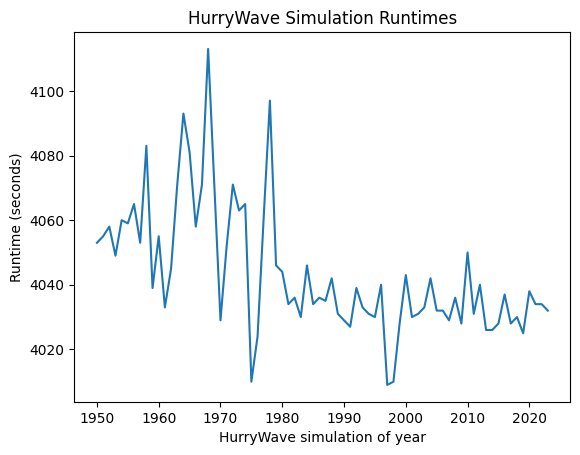

In [4]:
plt.plot(list(runtimes.keys()), list(runtimes.values()))
plt.xlabel("HurryWave simulation of year")
plt.ylabel("Runtime (seconds)")
plt.title("HurryWave Simulation Runtimes")
plt.show()

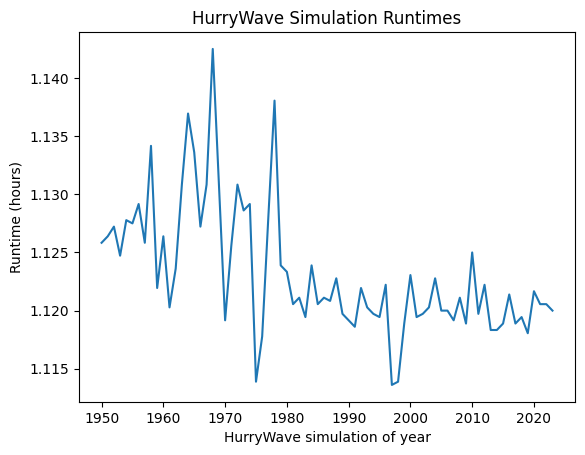

In [5]:
plt.plot(list(runtimes_hours.keys()), list(runtimes_hours.values()))
plt.xlabel("HurryWave simulation of year")
plt.ylabel("Runtime (hours)")
plt.title("HurryWave Simulation Runtimes")
plt.show()

In [6]:
print("Total runtime for all years:", sum(runtimes.values()), "seconds", "or", sum(runtimes.values()) / 3600, "hours")

Total runtime for all years: 299222.0 seconds or 83.11722222222222 hours


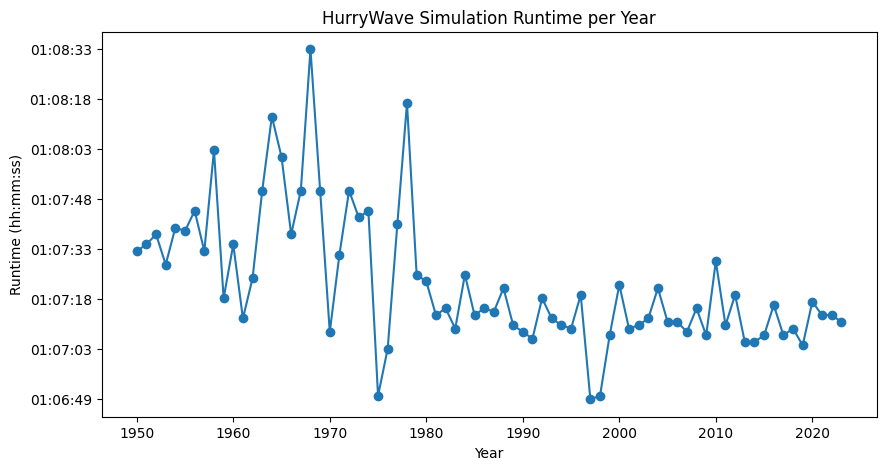

In [7]:
years = list(runtimes.keys())
total_seconds = list(runtimes.values())

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(years, total_seconds, marker='o')
ax.set_xlabel("Year")
ax.set_ylabel("Runtime (hh:mm:ss)")
ax.set_title("HurryWave Simulation Runtime per Year")

# Set regular y-ticks between min and max
yticks = np.linspace(min(total_seconds), max(total_seconds), num=8)
ax.set_yticks(yticks)

# Format y-tick labels as h:m:s
def seconds_to_hms(sec):
    h = int(sec // 3600)
    m = int((sec % 3600) // 60)
    s = int(sec % 60)
    return f"{h:02}:{m:02}:{s:02}"

ax.set_yticklabels([seconds_to_hms(y) for y in yticks])

plt.show()


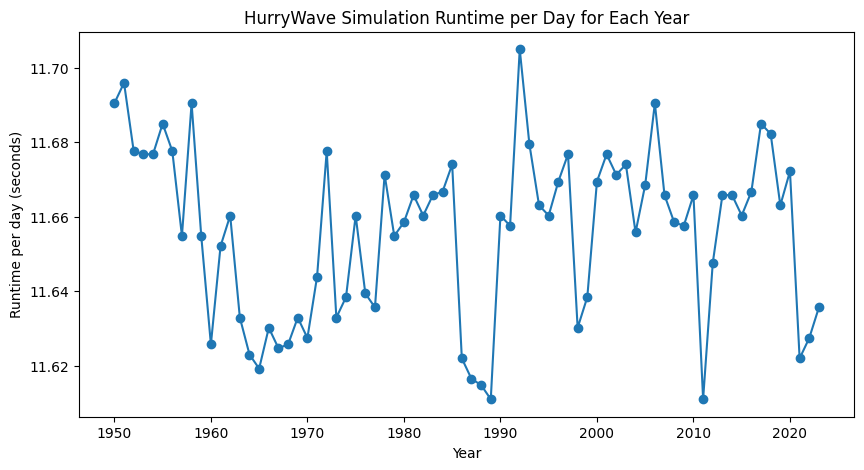

In [8]:
years = list(daily_runtimes.keys())
total_seconds = list(daily_runtimes.values())

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(years, total_seconds, marker='o')
ax.set_xlabel("Year")
ax.set_ylabel("Runtime per day (seconds)")
ax.set_title("HurryWave Simulation Runtime per Day for Each Year")

plt.show()